>### The code below takes multiple hd5 files from the Munn survey as input and outputs an array with the mean offsets of DDO51.

In [1]:
#Counting number of files in a directory and a list of all hd5 file names.  This will be used to create a blank array for mean offsets.

# Import modules
from astropy.io import fits
from astropy.table import Table
import numpy as np
import os, os.path

path, dirsyear, files = next(os.walk(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51"))

nights = []

for i in dirsyear:
    path, dirsnight, files = next(os.walk(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\{0}".format(i)))
    for j in dirsnight:
        path, dirs, filesnight = next(os.walk(r"C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\{0}\{1}\pcat".format(i,j)))
        nights += filesnight

#The variable dirs contains the names of all the folders containing hd5 files.  
#This can be referenced during construction of the array

files = np.array(nights)
mean = np.zeros(len(nights))
col1 = fits.Column(name='file', format='A15', array=files)
col2 = fits.Column(name='mean', format='D05', unit='DN', array=mean)
coldefs = fits.ColDefs([col1, col2])
moff = fits.BinTableHDU.from_columns(coldefs)
len(moff.data['file'])

#For loop to append mean offsets to array for each file
for i in nights:
    #Loading data from night one
    z = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\20{0}\{1}\pcat\{2}'.format(i[1:3],i[0:7],i))

    #loading dwarf locus data
    dat = Table.read(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\gaiad51_dwarflocus.fits')

    #Removing nans from Gaia BP and RP matched photometry
    ind = np.isnan(z['phot_bp_mean_mag'])
    tb = z['phot_bp_mean_mag']
    tr = z['phot_rp_mean_mag']
    dd = z['ddo51']
    ind = np.where((~np.isnan(tb))&(~np.isnan(tr))&(~np.isnan(dd)))

    #Remove any row with a nan in BP or RP
    tb = tb[ind]
    tr = tr[ind]
    dd = dd[ind]
    
    #Zero-point data
    #Calculate differences between photometric bands
    bprp = tb-tr
    bpd = tb-dd
    dt = np.dtype([('bprp',float),('bpd',float)])
    zerop = np.zeros(len(dd), dtype=dt)
    zerop['bprp'] = bprp
    zerop['bpd'] = bpd
    
    #Focus on values near the dwarf locus
    ind = np.where((zerop['bprp']<3)&(zerop['bpd']<3))
    zerop = zerop[ind]
    hist, xedges, yedges = np.histogram2d(zerop['bprp'],zerop['bpd'], [50,50])
    ind = np.where(hist == hist.max())
    
    #Find the location of highest density in the locus
    x0 = xedges[ind[0]][0]
    y0 = yedges[ind[1]][0]
    good = np.where((zerop['bpd']<(y0+0.15))&(zerop['bpd']>(y0-0.68))&(zerop['bprp']<(x0+2.17))&(zerop['bprp']>(x0-0.574)))
    zerop = zerop[good]
    
    #Calculate mean offset for field and append to fits table moff
    photint = np.interp(zerop['bprp'],dat['BPRP'],dat['BPD'])
    diff = zerop['bpd']  - photint

    m = np.mean(diff)
    loc = np.where(moff.data['file']==i)
    moff.data['mean'][loc] = m

moff.data['mean']

C:\Users\shebe\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


array([0.11686023, 0.05771012, 0.06551465, ..., 0.04954515, 0.03667743,
       0.09239255])

In [2]:
#Save array
np.save(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\moffsets.npy',moff.data)

>### Look at mean of means, median, and max/min.

In [3]:
#Load numpy rec array
t = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\moffsets.npy')

#Maximum and minimum mean offsets
print('Minimum mean offset: {0}'.format(min(t['mean'])))
print('Maximum mean offset: {0}'.format(max(t['mean'])))
print('Median: {0}'.format(np.median(t['mean'])))
print('Mean of all means: {0}'.format(np.mean(t['mean'])))

Minimum mean offset: -100.50419902311815
Maximum mean offset: 1.0671678294739355
Median: 0.0783413076726828
Mean of all means: 0.03244718999507937


>### Plot histogram excluding the outliers.

<IPython.core.display.Javascript object>


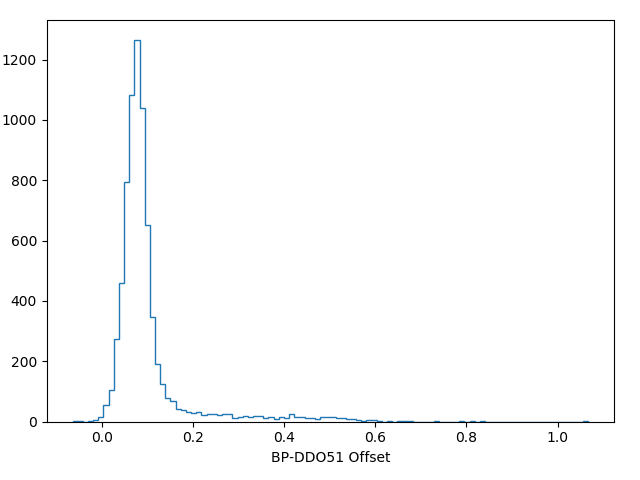

In [4]:
#Import libraries and functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib nbagg

#Load data
t = np.load(r'C:\Users\shebe\OneDrive\School\Graduate\Research\Nidever\Data\DDO51\moffsets.npy')

#Remove outliers
ind = np.where(t['mean']>-2)
t = t[ind]

#Define variable for plot/figure
fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('BP-DDO51 Offset')
plt.tight_layout()

x = ax.hist(t['mean'], histtype='step', bins=100, normed=False)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels)
plt.show()